## HistgGradientBoost Training Notebook
This notebook contains all the code to train two HistGradientBoost models not using and using one hot encoded year data as well as performance evaluation and SHAP feature importance exploration.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap as shap
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)

shap.initjs()

## Read Data

In [17]:
file_format = "png"
"""
Read in our targets and features from preprocessed data. We read in weather and array fraction datat seperately from dates to simplity training models with and without 
year data.
"""
targets = np.ravel(
    pd.read_csv(
        "../Data/prepro_data.csv",
        usecols=["rateUncorr"],
    ).to_numpy()
)

features = pd.read_csv(
    "../Data/prepro_data.csv",
    usecols=[
        "arrayFraction",
        "temperature",
        "pressure",
        "density",
        "density2HoursBefore",
    ],
)
dates = pd.read_csv(
    "../Data/prepro_data.csv",
    usecols=[
        "year_2013",
        "year_2014",
        "year_2015",
        "year_2016",
        "year_2017",
        "year_2018",
        "year_2019",
        "year_2020",
    ],
)
# used for making visualizations
years = np.ravel(
    pd.read_csv(
        "../Data/prepro_data.csv",
        usecols=["year"],
    ).to_numpy()
)
features_onehot = pd.concat([features, dates], axis=1)
# Train/test split and scaling, will be used for performance evaluation and SHAP feature importance
(
    features_train_onehot,
    features_test_onehot,
    targets_train_onehot,
    targets_test_onehot,
) = train_test_split(features_onehot, targets, test_size=0.3, random_state=42)

features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.3, random_state=42
)


In [18]:
features_onehot.describe()

,arrayFraction,temperature,pressure,density,density2HoursBefore,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
count,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000
mean,98.914714,11.719636,862.067789,1.052687,1.055390,0.117017,0.110872,0.099692,0.127011,0.136338,0.149755,0.116597,0.142717
std,1.297423,9.427390,4.045152,0.028082,0.037007,0.321441,0.313974,0.299590,0.332986,0.343148,0.356831,0.320941,0.349785
min,90.000000,-15.570000,843.833333,0.993300,0.957500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98.700000,4.800500,859.433333,1.030000,1.028333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99.300000,11.626667,862.033333,1.051000,1.054667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,99.600000,18.516667,864.700000,1.074000,1.081333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,38.423333,881.000000,1.134000,1.178667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
features.describe()

,arrayFraction,temperature,pressure,density,density2HoursBefore
count,221823.000000,221823.000000,221823.000000,221823.000000,221823.000000
mean,98.914714,11.719636,862.067789,1.052687,1.055390
std,1.297423,9.427390,4.045152,0.028082,0.037007
min,90.000000,-15.570000,843.833333,0.993300,0.957500
25%,98.700000,4.800500,859.433333,1.030000,1.028333
50%,99.300000,11.626667,862.033333,1.051000,1.054667
75%,99.600000,18.516667,864.700000,1.074000,1.081333
max,100.000000,38.423333,881.000000,1.134000,1.178667


In [20]:
years

array([2013, 2013, 2013, ..., 2020, 2020, 2020])

## Hyperparameters

In [ ]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=101)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rmse_scorer = make_scorer(
    mean_squared_error, greater_is_better=False, squared=False
)


parameters = {
    "max_depth": [3, 6, 10, None],
    "max_iter": [50, 100],
    "learning_rate": [0.05, 0.1],
    "loss": ["squared_error", "absolute_error"],
    "min_samples_leaf": [5, 10, 15],
}

## HistGradientBoost without Time Data

In [ ]:
model = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=45),
    param_grid=parameters,
    cv=inner_cv,
    scoring=mae_scorer,
    n_jobs=4,
    return_train_score=True,
)


In [39]:
model.fit(features, targets)

,estimator,HistGradientB...ndom_state=45)
,param_grid,"{'learning_rate': [0.05, 0.1], 'loss': ['squared_error', 'absolute_error'], 'max_depth': [3, 6, ...], 'max_iter': [50, 100], ...}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,4
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,loss,'absolute_error'


In [ ]:
print(
    "Best params, best score:", f"{model.best_score_:.4f}", model.best_params_
)

Best params, best score: -10.1788 {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 10}


In [ ]:
# Nested cross validated hyperparameter search
nested_model = GridSearchCV(
    HistGradientBoostingRegressor(random_state=43),
    parameters,
    cv=inner_cv,
    n_jobs=4,
    return_train_score=True,
    scoring=mae_scorer,
)
nested_score = cross_val_score(
    nested_model,
    X=features,
    y=targets,
    cv=outer_cv,
    n_jobs=4,
    scoring=mae_scorer,
)

In [42]:
print(
    f"Nested CV MAE (mean ± std): {-nested_score.mean():.5f} ± {nested_score.std():.5f}"
)

Nested CV MAE (mean ± std): 10.18202 ± 0.03152


Test MAE: 10.11709
Test R²: 0.81109


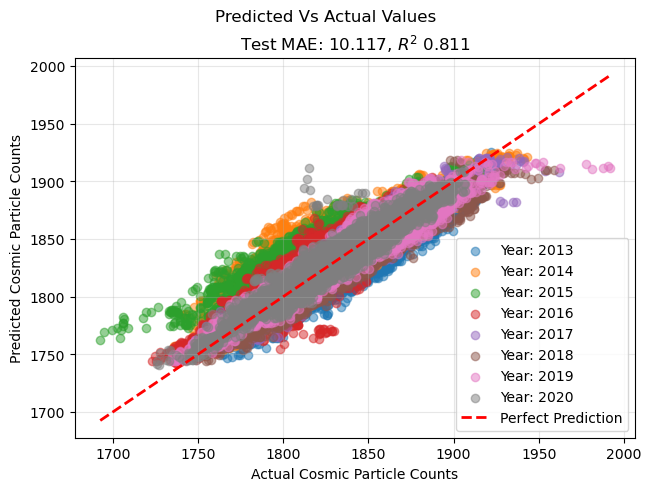

In [ ]:
# Create model with your best parameters
best_model = HistGradientBoostingRegressor(
    max_depth=None,
    max_iter=100,
    learning_rate=0.1,
    loss="absolute_error",
    min_samples_leaf=10,
)
# Train the model
best_model.fit(features_train, targets_train)
# Make predictions on test set
y_pred = best_model.predict(features_test)
# Calculate test performance
test_mae = mean_absolute_error(targets_test, y_pred)
test_r2 = r2_score(targets_test, y_pred)
print(f"Test MAE: {test_mae:.5f}")
print(f"Test R²: {test_r2:.5f}")
"""
Generate plot comparing the predicted uncorrected scaler rate vs the actual scaler rate. 
Grouped by year to see if certain years are performing worse than others
"""
fig, ax = plt.subplots(layout="constrained")
# Logic to group shuffled features to the correct year
for year in np.unique(years):
    year_idxs = np.argwhere(
        year == years
    )  # find indexs of current year in original dataset
    idxs = np.isin(features_test.index, year_idxs).nonzero()[
        0
    ]  # find the new index of instances in shuffled test set
    ax.scatter(
        targets_test[idxs], y_pred[idxs], alpha=0.5, label=f"Year: {year}"
    )  # Scatter plot of predictions vs actual
# Perfect prediction line (y=x)
min_val = min(targets_test.min(), y_pred.min())
max_val = max(targets_test.max(), y_pred.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    linewidth=2,
    label="Perfect Prediction",
)

ax.set_xlabel("Actual Cosmic Particle Counts")
ax.set_ylabel("Predicted Cosmic Particle Counts")
ax.set_title(f"Test MAE: {test_mae:.3f}, $R^{2}$ {test_r2:.3f}")
fig.suptitle("Predicted Vs Actual Values")
# Add grid, legend and save plot to plots directory
ax.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.savefig(
    f"../plots/pred_vs_act_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)

### Final Results 

MAE = 10.17 +/- 0.03

## SHAP Exploration

In [ ]:
# Tree explaner used in force plot
explainer = shap.TreeExplainer(
    best_model, feature_perturbation="tree_path_dependent"
)
shap_expl = explainer(features_test)
expected_value = shap_expl.base_values
shap_values = shap_expl.values


In [46]:
shap.plots.force(
    explainer.expected_value,
    shap_values[:1000],
    features=features_test.to_numpy()[:1000],
    feature_names=features_test.columns,
)

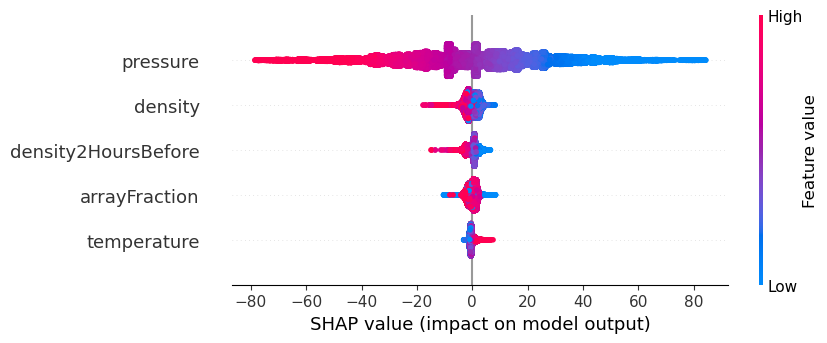

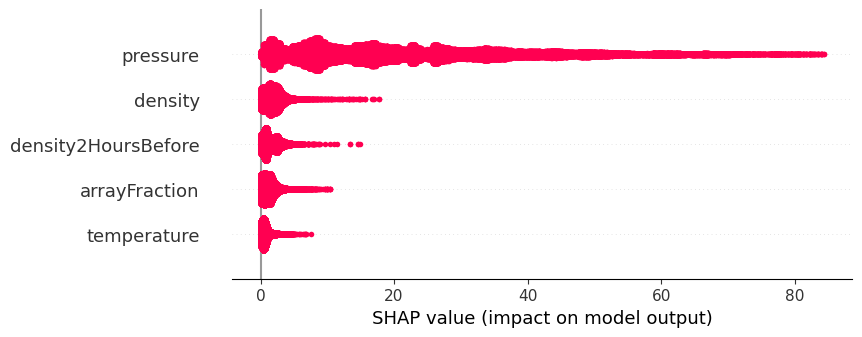

In [ ]:
shap.plots.beeswarm(shap_expl, max_display=40, show=False)
plt.savefig(
    f"../plots/shap_beeswarm_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close()

shap.plots.beeswarm(
    shap.Explanation(
        values=shap_expl.values,
        base_values=shap_expl.base_values,
        data=shap_expl.data,
        feature_names=features_test.columns,
    ).abs,  # Beeswarm using absolute SHAP values
    color="shap_red",
    max_display=40,
    show=False,
)
plt.savefig(
    f"../plots/shap_beeswarm_abs_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close()


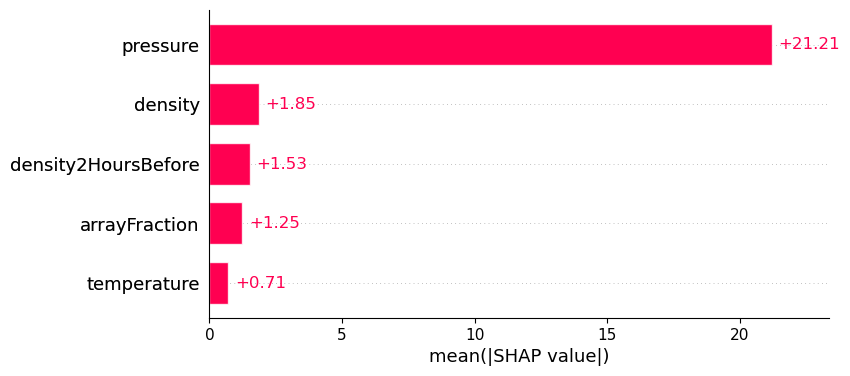

In [ ]:
# Plot that shows the global feature importance
shap.plots.bar(shap_expl, show=False)
plt.savefig(
    f"../plots/shap_bar_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close()


## HistGradientBoosting With Onehot Encoded Time Data

In [ ]:
model_onehot = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=45),
    param_grid=parameters,
    cv=inner_cv,
    scoring=mae_scorer,
    n_jobs=4,
    return_train_score=True,
)


In [58]:
model_onehot.fit(features_onehot, targets)

,estimator,HistGradientB...ndom_state=45)
,param_grid,"{'learning_rate': [0.05, 0.1], 'loss': ['squared_error', 'absolute_error'], 'max_depth': [3, 6, ...], 'max_iter': [50, 100], ...}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,4
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,loss,'squared_error'


In [ ]:
print(
    "Best params, best score:",
    f"{model_onehot.best_score_:.4f}",
    model_onehot.best_params_,
)

Best params, best score: -6.5901 {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 10}


In [ ]:
# Nested cross validated hyperparameter search
nested_model = GridSearchCV(
    HistGradientBoostingRegressor(random_state=50),
    parameters,
    cv=inner_cv,
    # verbose=2,
    n_jobs=4,
    return_train_score=True,
    scoring=mae_scorer,
)
nested_score_onehot = cross_val_score(
    nested_model,
    X=features_onehot,
    y=targets,
    cv=outer_cv,
    n_jobs=4,
    scoring=mae_scorer,
)

In [61]:
print(
    f"Nested CV MAE (mean ± std): {-nested_score_onehot.mean():.5f} ± {nested_score_onehot.std():.5f}"
)

Nested CV MAE (mean ± std): 6.59223 ± 0.02546


## Model Performance Evaluation

Test MAE: 6.56477
Test R²: 0.92404


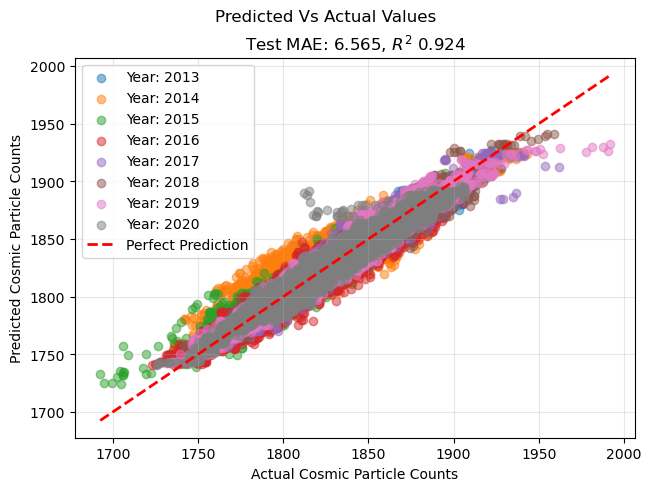

In [ ]:
# Create model with your best parameters
best_model_onehot = HistGradientBoostingRegressor(
    max_depth=None,
    max_iter=100,
    learning_rate=0.1,
    loss="squared_error",
    min_samples_leaf=10,
)


# Train the model
best_model_onehot.fit(features_train_onehot, targets_train_onehot)
# Make predictions on test set
y_pred_onehot = best_model_onehot.predict(features_test_onehot)
# Calculate test performance
test_mae_onehot = mean_absolute_error(targets_test_onehot, y_pred_onehot)
test_r2_onehot = r2_score(targets_test_onehot, y_pred_onehot)
print(f"Test MAE: {test_mae_onehot:.5f}")
print(f"Test R²: {test_r2_onehot:.5f}")
fig, ax = plt.subplots(layout="constrained")
# Logic to group shuffled features to the correct year
for year in np.unique(years):
    year_idxs = np.argwhere(
        year == years
    )  # find indexs of current year in original dataset
    idxs = np.isin(features_test_onehot.index, year_idxs).nonzero()[
        0
    ]  # find the new index of instances in shuffled test set
    ax.scatter(
        targets_test_onehot[idxs],
        y_pred_onehot[idxs],
        alpha=0.5,
        label=f"Year: {year}",
    )  # Scatter plot of predictions vs actual
# Perfect prediction line (y=x)
min_val = min(targets_test_onehot.min(), y_pred.min())
max_val = max(targets_test_onehot.max(), y_pred.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    linewidth=2,
    label="Perfect Prediction",
)
ax.set_xlabel("Actual Cosmic Particle Counts")
ax.set_ylabel("Predicted Cosmic Particle Counts")
ax.set_title(f"Test MAE: {test_mae_onehot:.3f}, $R^{2}$ {test_r2_onehot:.3f}")
fig.suptitle("Predicted Vs Actual Values")
# Add grid, legend and save plot to plots directory
ax.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.savefig(
    f"../plots/pred_vs_act_onehot_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close(fig)

### Final Results 

MAE = 6.59 +/- 0.03

## SHAP Exploration

In [ ]:
# Tree explaner used in force plot
explainer_onehot = shap.TreeExplainer(
    best_model_onehot, feature_perturbation="tree_path_dependent"
)
shap_expl_onehot = explainer_onehot(features_test_onehot)
expected_value_onehot = shap_expl_onehot.base_values
shap_values_onehot = shap_expl_onehot.values


In [65]:
shap.plots.force(
    explainer_onehot.expected_value,
    shap_values_onehot[:1000],
    features=features_test_onehot.to_numpy()[:1000],
    feature_names=features_test_onehot.columns,
)

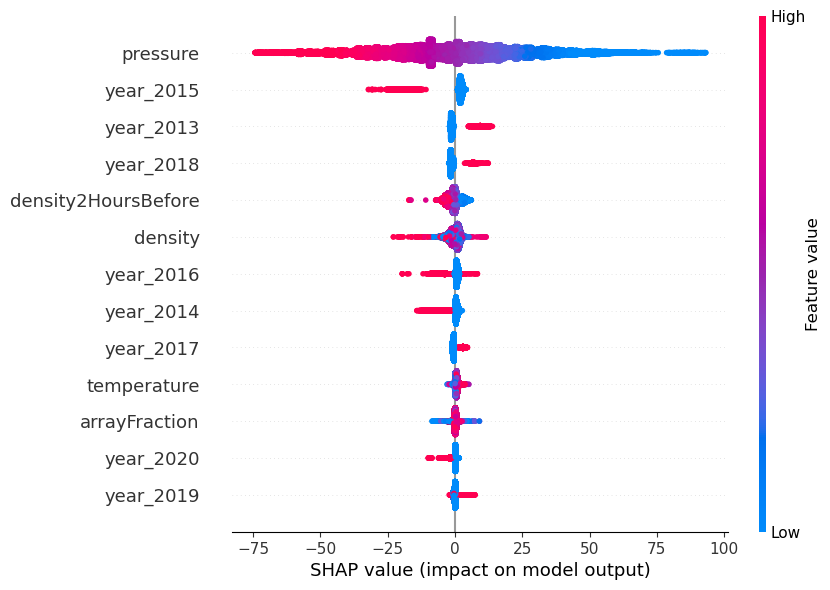

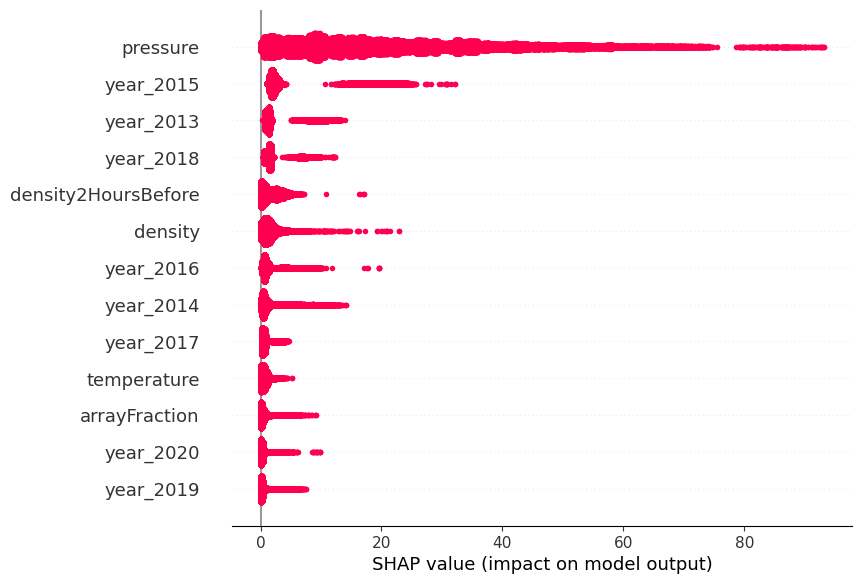

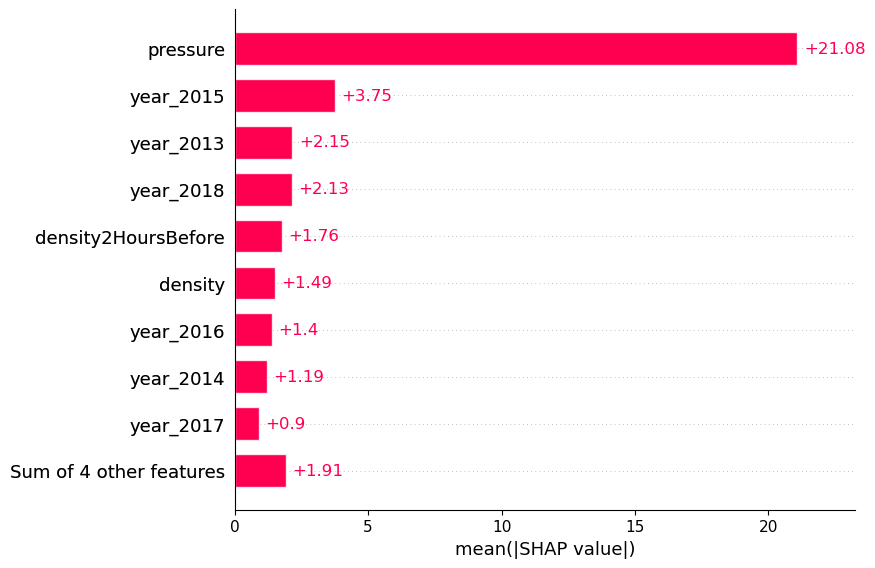

In [ ]:
shap.plots.beeswarm(shap_expl_onehot, max_display=40, show=False)
plt.savefig(
    f"../plots/shap_onehot_beeswarm_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close()

shap.plots.beeswarm(
    shap.Explanation(
        values=shap_expl_onehot.values,
        base_values=shap_expl_onehot.base_values,
        data=shap_expl_onehot.data,
        feature_names=features_test_onehot.columns,
    ).abs,  # Beeswarm using absolute SHAP values
    color="shap_red",
    max_display=40,
    show=False,
)
plt.savefig(
    f"../plots/shap_onehot_beeswarm_abs_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close()


# Plot that shows the global feature importance
shap.plots.bar(shap_expl_onehot, show=False)
plt.savefig(
    f"../plots/shap_onehot_bar_hist.{file_format}",
    format=file_format,
    dpi="figure",
    bbox_inches="tight",
)
plt.show()
plt.close()
